In [1]:
#====================================================================================
# MLM 방식을 이용한 Further pre-traning 방식 구현 예제
# 참고 소스 : https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c 참조 바람
#====================================================================================
import torch
import copy
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertConfig, BertForMaskedLM, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup
from os import sys
sys.path.append('..')
from myutils import GPU_info, seed_everything, mlogging, AccuracyForMLM, SaveBERTModel

#====================================================================================
# bitsandbytes 라이브러리 설치
# => 8-bit optimizer 사용을 위해 cuda 버전을 확인하고, 해당 버전에 맞는 bitsandbytes 라이브러리 설치함
#   Bitsandbytes is a lightweight wrapper around CUDA custom functions, 
#   in particular 8-bit optimizers and quantization functions.
# => 참조 : https://github.com/facebookresearch/bitsandbytes
#
#!conda list | grep cudatoolkit     # cuda 버전 확인
#!pip install bitsandbytes-cuda113  # 해당 버전에 맞는 bitsandbytes 설치 (버전이 11.3 이면, cuda113 으로 설치)
#====================================================================================
import bitsandbytes as bnb

logfilepath:../log/bwdataset_2022-04-21.log
logfilepath:../log/qnadataset_2022-04-21.log


In [2]:
################################################
# GPU 보다 큰 모델을 FineTuning 하기 위한 방법
# -> "CUDA 메모리 오류" 문제를 해결하기 위한 몇가지 방법
# 참고 : https://medium.com/@bestasoff/how-to-fine-tune-very-large-model-if-it-doesnt-fit-on-your-gpu-3561e50859af
################################################
#================================================
# 1.gkadient_checkpoint 적용
# => backprop 하기전, 순차적으로 피드포워드 된 노드들의 값을 모두 메모리에 저장해 두는 대신, 
# 체크포인트 방식으로, 필요한 노드들의 값만 메모리에 저장해 두는 방식
# => 사용법 : model.gradient_checkpointing_enable()
#
gradient_checkpoint = True
#================================================
# 2. micro_batch/Gradient accumulation(마이크로 배치&기울기 축적)
# => 배치사이즈는 8로 하고, 대신에 accumulation_steps= 4로 해서, 4번 기울기 축적을 누적해서 
# 32배치사이즈와 동일한 효과를 주는 방식
# => *훈련시간이 1.3배 더 증가함
#
micro_batch = True
micro_batch_size = 8
accumulation_steps = 4
#================================================
# 3. 8bit-adam optimizer 사용
# => 기존 32bit Adam 옵티마이져 대신 8bit Aadmin 옵티마이져를 사용하여, 2^32 -> 2^8 으로 메모리를낮춤
# => *bert 모델에서 훈련 테스트시 gpu 메모리가 낮아지지는 않았음
# => 사용방법 : optimizer = bnb.optim.Adam8bit(model.parameters(), lr=learning_rate, betas=(0.9, 0.995))
adam8bit_use = False
#================================================
# 4. Mixed-precision training(혼합 정밀도 훈련)
# => 훈련은 gpu 모델을 이용하는 데신, gpu 모델 크기를 반으로 줄여(FP16) 사용하고,
# 대신 optimizer는 cpu 모델을 이용하여 gd를 업데이트 하는 방식
# => gpu 모델과 cpu 모델 2개 필요. 훈련시간이 gpu일때 보다 10배정도 증가, 
# => adam8bit 와 함께 동작시, 'Error an illegal memory access was encountered at line 276 in file /private/home/timdettmers/git/bitsandbytes/csrc/ops.cu' 에러 발생(*원인 모름)
mix_precision = True

In [3]:
# 훈련시킬 말뭉치(사전 만들때 동일한 말뭉치 이용)
#input_corpus = "../korpora/kowiki_20190620/wiki_20190620_mecab_false_0311.txt"
input_corpus = "../korpora/kowiki_20190620/wiki_20190620_small.txt"

# eval 말뭉치 
eval_corpus = "../korpora/kowiki_20190620/wiki_eval_test.txt"

# 기존 사전훈련된 모델
model_path = "../model/bert/bert-multilingual-cased"

# 기존 사전 + 추가된 사전 파일
vocab_path="../tokenizer/my_vocab"
#vocab_path="../tokenizer/wiki_20190620_nouns_0324"

# 출력
OUTPATH = '../model/bert/bert-multilingual-cased-0421/'

token_max_len = 128
batch_size = 32


In [4]:
device = GPU_info()
print(device)

#seed 설정
seed_everything(222)

#logging 설정
logger =  mlogging(loggername="bertfpt3", logfilename="../log/bertfpt3")

True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../log/bertfpt3_2022-04-21.log


In [5]:
# tokeinzier 생성
# tokenizer 생성
# => BertTokenizer, BertTokenizerFast 둘중 사용하면됨

#tokenizer = BertTokenizer(vocab_file=vocab_path, max_len=token_max_len, do_lower_case=False)
tokenizer = BertTokenizer.from_pretrained(vocab_path, max_len=token_max_len, do_lower_case=False)
# tokenizer = BertTokenizerFast(vocab_file=vocab_file, max_len=token_max_len, do_lower_case=False)


# speical 토큰 계수 + vocab 계수 - 이미 vocab에 포함된 speical 토큰 계수(5)
vocab_size = len(tokenizer.all_special_tokens) + tokenizer.vocab_size
#vocab_size = len(tokenizer.all_special_tokens) + tokenizer.vocab_size - 5 + 1
#vocab_size = len(tokenizer.all_special_tokens) + tokenizer.vocab_size - 5
print('special_token_size: {}, tokenizer.vocab_size: {}'.format(len(tokenizer.all_special_tokens), tokenizer.vocab_size))
print('vocab_size: {}'.format(vocab_size))
print('tokenizer_len: {}'.format(len(tokenizer)))

# 모델 로딩 further pre-training 
#config = BertConfig.from_pretrained(model_path)
#model = BertForMaskedLM.from_pretrained(model_path, from_tf=bool(".ckpt" in model_path), config=config) 

##############################################################################
# mix_precision 적용인 경우 => gpu_Model 사이즈는 반으로 줄임
if mix_precision:
    model = BertForMaskedLM.from_pretrained(model_path).half()
else:
    model = BertForMaskedLM.from_pretrained(model_path)

#################################################################################
# 모델 embedding 사이즈를 tokenizer 크기 만큼 재 설정함.
# 재설정하지 않으면, 다음과 같은 에러 발생함
# CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)` CUDA 에러가 발생함
#  indexSelectLargeIndex: block: [306,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
#
#     해당 오류는 기존 Embedding(8002, 768, padding_idx=1) 처럼 입력 vocab 사이즈가 8002인데,
#     0~8001 사이를 초과하는 word idx 값이 들어가면 에러 발생함.
#################################################################################
model.resize_token_embeddings(len(tokenizer))
model.to(device)

#############################################################################
# mix_precision 적용인 경우 => cpumodel을 하나 생성
if mix_precision:
    cpu_model = BertForMaskedLM.from_pretrained(model_path)  
    cpu_model.resize_token_embeddings(len(tokenizer))
    logger.info(f'==>*mix_precision 적용=>cpu_model 생성')
    cpu_model.to('cpu')
#############################################################################


special_token_size: 5, tokenizer.vocab_size: 149793
vocab_size: 149798
tokenizer_len: 149793


Some weights of the model checkpoint at ../model/bert/bert-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../model/bert/bert-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializi

In [6]:
from torch.utils.data import DataLoader, RandomSampler
import sys
sys.path.append('..')
from myutils import MLMDataset

#######################################################################
# micro_batch_size 적용인 경우에는 batch_size를 micro_batch_size 로 변경함
if micro_batch:
    batch_size = micro_batch_size
    logger.info(f'==>*micro_batch 적용, accumulation_steps:{accumulation_steps}')
#######################################################################

# 각 스페셜 tokenid를 구함
CLStokenid = tokenizer.convert_tokens_to_ids('[CLS]')
SEPtokenid = tokenizer.convert_tokens_to_ids('[SEP]')
UNKtokenid = tokenizer.convert_tokens_to_ids('[UNK]')
PADtokenid = tokenizer.convert_tokens_to_ids('[PAD]')
MASKtokenid = tokenizer.convert_tokens_to_ids('[MASK]')
print('CLSid:{}, SEPid:{}, UNKid:{}, PADid:{}, MASKid:{}'.format(CLStokenid, SEPtokenid, UNKtokenid, PADtokenid, MASKtokenid))


train_dataset = MLMDataset(corpus_path = input_corpus,
                           tokenizer = tokenizer, 
                           CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                           SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                           UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                           PADtokenid = PADtokenid,    # [PAD] 토큰 id
                           Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                           max_sequence_len=token_max_len,  # max_sequence_len)
                           mlm_probability=0.15,
                           overwrite_cache=True
                          )


# 학습 dataloader 생성
# => tenosor로 만듬
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          num_workers=3
                         )

#===============================================================================
# eval dataloader 생성
eval_dataset = MLMDataset(corpus_path = eval_corpus,
                          tokenizer = tokenizer, 
                          CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                          SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                          UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                          PADtokenid = PADtokenid,    # [PAD] 토큰 id
                          Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                          max_sequence_len=token_max_len,  # max_sequence_len)
                          mlm_probability=0.15,
                          overwrite_cache=True
                          )


# eval dataloader 생성
# => tenosor로 만듬
eval_loader = DataLoader(eval_dataset, 
                         batch_size=batch_size, 
                         #shuffle=True, # dataset을 섞음
                         sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                         num_workers=3
                         )
#===============================================================================

print(train_dataset[0])

2022-04-21 13:24:24,056 - bertfpt3 - INFO - ==>*micro_batch 적용, accumulation_steps:4


CLSid:101, SEPid:102, UNKid:100, PADid:0, MASKid:103
*corpus:../korpora/kowiki_20190620/wiki_20190620_small.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:101, SEPtokenid:102, UNKtokenid:100, PADtokeinid:0, Masktokeid:103
*total_line: 10000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-21 13:24:28,676 - bwpdataset - INFO - ==>[Start] cached file create: ../korpora/kowiki_20190620/cached_lm_BertTokenizer_128_wiki_20190620_small.txt
2022-04-21 13:24:28,784 - bwpdataset - INFO - <==[End] Saving features into cached file ../korpora/kowiki_20190620/cached_lm_BertTokenizer_128_wiki_20190620_small.txt [took 0.106 s]


*corpus:../korpora/kowiki_20190620/wiki_eval_test.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:101, SEPtokenid:102, UNKtokenid:100, PADtokeinid:0, Masktokeid:103
*total_line: 114


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

2022-04-21 13:24:28,952 - bwpdataset - INFO - ==>[Start] cached file create: ../korpora/kowiki_20190620/cached_lm_BertTokenizer_128_wiki_eval_test.txt
2022-04-21 13:24:28,955 - bwpdataset - INFO - <==[End] Saving features into cached file ../korpora/kowiki_20190620/cached_lm_BertTokenizer_128_wiki_eval_test.txt [took 0.002 s]


{'input_ids': tensor([   101, 123809,   9551,    107,    103,    107,    103, 126023,    103,
        120115, 120169,  23545,    103,  48506,  70672,  30919,    103,    102,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   

In [7]:
##################################################
epochs = 3            # epochs
learning_rate = 3e-5  # 학습률
##################################################

##################################################
# adam8bit_use & mix_precision 적용
if adam8bit_use & mix_precision:
    optimizer = bnb.optim.Adam8bit(cpu_model.parameters(), lr=learning_rate, betas=(0.9, 0.995))
    logger.info(f'==>*adam8bit_use & mix_precision 적용')
# adam8bit만 적용한 경우 
elif adam8bit_use:
    optimizer = bnb.optim.Adam8bit(model.parameters(), lr=learning_rate, betas=(0.9, 0.995))
    logger.info(f'==>*adam8bit_use 적용')
# mix_precision 만 적용한 경우 
elif mix_precision:
     # optimizer 적용
    optimizer = AdamW(cpu_model.parameters(), lr=learning_rate, eps=1e-8)
    logger.info(f'==>*mix_precision 적용')
else:
    # optimizer 적용
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8) 
##################################################

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(len(train_loader)*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
total_test_correct = 0
total_test_len = 0
    
list_train_loss = []
list_train_acc = []
list_validation_acc = []

##################################################
# gradient_checkpoint 설정한 경우 
if gradient_checkpoint:
    model.gradient_checkpointing_enable()
    logger.info(f'==>*gradient_checkpoint 적용')
##################################################
    
if micro_batch:
    logger.info(f'==>*micro_batch 적용, accumulation_steps:{accumulation_steps}')
   
logger.info(f'*batch_size:{batch_size}, epochs:{epochs}, lr:{learning_rate}, token_max_len:{token_max_len}')

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    if mix_precision:
        cpu_model.train()
        
    for batch_idx, data in enumerate(tqdm(train_loader)):
    
        #optimizer.zero_grad()
         
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)       
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids,
                       labels=labels)
        
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
        
        #######################################################################################
        # micro_batch 사용 하는 경우
        if micro_batch:
            loss = loss / accumulation_steps
        #######################################################################################
        
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
            
        #######################################################################################
        # micro_batch 사용 하는 경우
        if micro_batch:
            if ((batch_idx + 1) % accumulation_steps == 0) or (batch_idx + 1 == len(train_loader)):
                # mix_precison 사용인경우
                if mix_precision:
                    for p_gpu, p_cpu in zip(model.parameters(), cpu_model.parameters()):
                        p_cpu.grad = p_gpu.grad.cpu().to(torch.float32)
                        #p_cpu.grad = copy.copy(p_gpu.grad.cpu().to(torch.float32))   
             
                    model.zero_grad()
                    optimizer.step()
                    scheduler.step()  # 학습률 감소
                    model.load_state_dict(cpu_model.state_dict())
                    cpu_model.zero_grad()
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   
                    optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
                    scheduler.step()  # 학습률 감소
                    model.zero_grad()# 그래디언트 초기화
        else: 
                # mix_precison 사용인경우
                if mix_precision:
                    for p_gpu, p_cpu in zip(model.parameters(), cpu_model.parameters()):
                        p_cpu.grad = p_gpu.grad.cpu().to(torch.float32)
                        #p_cpu.grad = copy.copy(p_gpu.grad.cpu().to(torch.float32)) 
                        
                    model.zero_grad()
                    optimizer.step()
                    scheduler.step()  # 학습률 감소
                    model.load_state_dict(cpu_model.state_dict())
                    cpu_model.zero_grad()
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
                    optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
                    scheduler.step()  # 학습률 감소
                    model.zero_grad()# 그래디언트 초기화
  
        
        #######################################################################################
           
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
            
            #===========================================
            # 정확도(Accurarcy) 계산
            correct = AccuracyForMLM(logits, labels, attention_mask)
            total_correct += correct.sum().item() 
            total_len += attention_mask.sum().item() # 단어 총 수는 attension_mask가 1(True) 인 것들의 합
            #=========================================
                
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                train_acc = total_correct/total_len
                       
                ####################################################################
                # 주기마다 eval(validataion) 데이터로 평가하여 손실류 계산함.
                # 평가 시작
                model.eval()

                #for data in tqdm(eval_loader):
                for data in eval_loader:
                    # 입력 값 설정
                    input_ids = data['input_ids'].to(device)
                    attention_mask = data['attention_mask'].to(device)
                    token_type_ids = data['token_type_ids'].to(device)       
                    labels = data['labels'].to(device)

                    with torch.no_grad():
                        # 모델 실행
                        outputs = model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       labels=labels)

                        # 출력값 loss,logits를 outputs에서 얻어옴
                        #loss = outputs.loss
                        logits = outputs.logits

                        #===========================================
                        # 정확도(Accurarcy) 계산
                        correct = AccuracyForMLM(logits, labels, attention_mask)
                        total_test_correct += correct.sum().item() 
                        total_test_len += attention_mask.sum().item()  # 단어 총 수는 attension_mask가 1(True) 인 것들의 합
                        #=========================================

                val_acc = total_test_correct/total_test_len
                    
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Acc: {:.4f}, Val Acc:{}'.format(epoch+1, epochs, itr, train_loss, train_acc, val_acc))
                    
                list_train_loss.append(train_loss)
                list_train_acc.append(train_acc)
                list_validation_acc.append(val_acc)
                 
                # 변수들 초기화    
                total_loss = 0
                total_len = 0
                total_correct = 0
                total_test_correct = 0
                total_test_len = 0
                ####################################################################

            #if itr % save_steps == 0:
                #전체모델 저장
                #SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)
        
        itr+=1
   

2022-04-21 13:24:28,993 - bertfpt3 - INFO - ==>*mix_precision 적용
2022-04-21 13:24:28,996 - bertfpt3 - INFO - ==>*gradient_checkpoint 적용
2022-04-21 13:24:28,997 - bertfpt3 - INFO - ==>*micro_batch 적용, accumulation_steps:4
2022-04-21 13:24:28,998 - bertfpt3 - INFO - *batch_size:8, epochs:3, lr:3e-05, token_max_len:128


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1228 [00:00<?, ?it/s]

2022-04-21 13:25:19,148 - bertfpt3 - INFO - [Epoch 1/3] Iteration 122 -> Train Loss: 3.4217, Train Acc: 0.5849, Val Acc:0.6005459508644222
2022-04-21 13:26:01,562 - bertfpt3 - INFO - [Epoch 1/3] Iteration 244 -> Train Loss: 1.8264, Train Acc: 0.5593, Val Acc:0.5486806187443131
2022-04-21 13:26:43,997 - bertfpt3 - INFO - [Epoch 1/3] Iteration 366 -> Train Loss: 0.4147, Train Acc: 0.5457, Val Acc:0.599939338792842
2022-04-21 13:27:25,305 - bertfpt3 - INFO - [Epoch 1/3] Iteration 488 -> Train Loss: 0.2357, Train Acc: 0.6192, Val Acc:0.6642402183803457
2022-04-21 13:28:06,246 - bertfpt3 - INFO - [Epoch 1/3] Iteration 610 -> Train Loss: 0.1450, Train Acc: 0.6998, Val Acc:0.7719138610858356
2022-04-21 13:28:48,694 - bertfpt3 - INFO - [Epoch 1/3] Iteration 732 -> Train Loss: 0.1004, Train Acc: 0.8004, Val Acc:0.835304822565969
2022-04-21 13:29:27,956 - bertfpt3 - INFO - [Epoch 1/3] Iteration 854 -> Train Loss: 0.0747, Train Acc: 0.8547, Val Acc:0.8650288140734
2022-04-21 13:30:10,107 - bertfp

  0%|          | 0/1228 [00:00<?, ?it/s]

2022-04-21 13:32:16,391 - bertfpt3 - INFO - [Epoch 2/3] Iteration 1342 -> Train Loss: 0.0959, Train Acc: 0.8020, Val Acc:0.8908098271155596
2022-04-21 13:32:53,261 - bertfpt3 - INFO - [Epoch 2/3] Iteration 1464 -> Train Loss: 0.0476, Train Acc: 0.8972, Val Acc:0.89171974522293
2022-04-21 13:33:30,930 - bertfpt3 - INFO - [Epoch 2/3] Iteration 1586 -> Train Loss: 0.0469, Train Acc: 0.8989, Val Acc:0.8944494995450409
2022-04-21 13:34:09,157 - bertfpt3 - INFO - [Epoch 2/3] Iteration 1708 -> Train Loss: 0.0444, Train Acc: 0.9007, Val Acc:0.8962693357597816
2022-04-21 13:34:46,099 - bertfpt3 - INFO - [Epoch 2/3] Iteration 1830 -> Train Loss: 0.0435, Train Acc: 0.9019, Val Acc:0.8965726417955717
2022-04-21 13:35:25,450 - bertfpt3 - INFO - [Epoch 2/3] Iteration 1952 -> Train Loss: 0.0440, Train Acc: 0.9021, Val Acc:0.8968759478313618
2022-04-21 13:36:03,278 - bertfpt3 - INFO - [Epoch 2/3] Iteration 2074 -> Train Loss: 0.0452, Train Acc: 0.9020, Val Acc:0.8971792538671519
2022-04-21 13:36:45,12

  0%|          | 0/1228 [00:00<?, ?it/s]

2022-04-21 13:38:49,554 - bertfpt3 - INFO - [Epoch 3/3] Iteration 2562 -> Train Loss: 0.0523, Train Acc: 0.8817, Val Acc:0.8993023961176827
2022-04-21 13:39:30,393 - bertfpt3 - INFO - [Epoch 3/3] Iteration 2684 -> Train Loss: 0.0387, Train Acc: 0.9089, Val Acc:0.8993023961176827
2022-04-21 13:40:09,794 - bertfpt3 - INFO - [Epoch 3/3] Iteration 2806 -> Train Loss: 0.0425, Train Acc: 0.9049, Val Acc:0.9002123142250531
2022-04-21 13:40:51,425 - bertfpt3 - INFO - [Epoch 3/3] Iteration 2928 -> Train Loss: 0.0436, Train Acc: 0.9050, Val Acc:0.8977858659387322
2022-04-21 13:41:33,336 - bertfpt3 - INFO - [Epoch 3/3] Iteration 3050 -> Train Loss: 0.0440, Train Acc: 0.9082, Val Acc:0.8977858659387322
2022-04-21 13:42:12,743 - bertfpt3 - INFO - [Epoch 3/3] Iteration 3172 -> Train Loss: 0.0427, Train Acc: 0.9086, Val Acc:0.8989990900818926
2022-04-21 13:42:53,277 - bertfpt3 - INFO - [Epoch 3/3] Iteration 3294 -> Train Loss: 0.0443, Train Acc: 0.9052, Val Acc:0.9002123142250531
2022-04-21 13:43:33,

In [8]:
'''
import copy
for p_gpu, p_cpu in zip(model.parameters(), cpu_model.parameters()):
    #p1 = p_gpu.grad.cpu().to(torch.float32)
    print(p_gpu.grad.cpu().to(torch.float32))
    p_cpu.grad = copy.copy(p_gpu.grad.cpu().to(torch.float32))   
    print(p_cpu.grad)
'''

'\nimport copy\nfor p_gpu, p_cpu in zip(model.parameters(), cpu_model.parameters()):\n    #p1 = p_gpu.grad.cpu().to(torch.float32)\n    print(p_gpu.grad.cpu().to(torch.float32))\n    p_cpu.grad = copy.copy(p_gpu.grad.cpu().to(torch.float32))   \n    print(p_cpu.grad)\n'

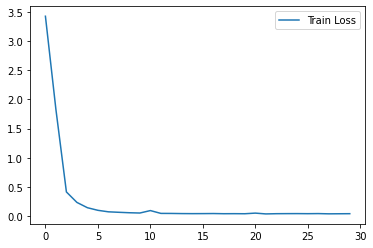

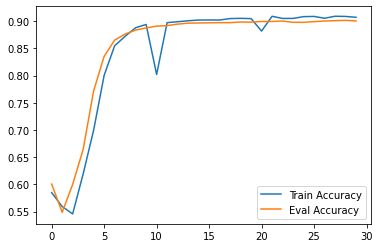

In [9]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
#plt.plot(list_train_acc, label='Train Accuracy')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()

plt.plot(list_train_acc, label='Train Accuracy')
plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()

In [10]:
# 모델 저장
#save_model(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)